# MLLB Deep Learning Report </font></br></div>



Course: Machine Learning Lab





---

Student:

Mefteh Aya   aya.mefteh@alumnos.upm.es
Abid Brahim 

This report is part of MLLB class, Master of Science in signal processing and machine learning for big data. It covers the application of different deep learning approaches for the segmentation of abdominal organs from MRI images, inspired by the Combined (CT-MR) Healthy Abdominal Organ Segmentation
(CHAOS) Challenge 2019.
This study was carried out collaboratively by two students, sharing both the ex-
perimental and analytical aspects of the work.

This report is a preliminary draft. The first part presents the progress made so far, while the second part outlines the planned and ongoing experiments that will be further developed in the final version.

Data Set downloaded from: https://chaos.grand-challenge.org/Download/

## 1.Introduction


Accurate segmentation of abdominal organs such as the liver, kidneys, and spleen is crucial for many complex medical procedures, including surgical planning and 3D visualization. However, the anatomical variability of the abdomen and imaging limitations make reliable segmentation challenging. The CHAOS 2019 Challenge provides a standardized framework to develop and evaluate segmentation algorithms under realistic MRI conditions.

This project focuses on Task 5 of the challenge, which involves MRI-only segmentation using T1-DUAL and T2-SPIR sequences. The main objective is to develop, implement, and assess deep learning models for automatic multi-organ segmentation. Key goals include understanding the dataset structure, performing exploratory data analysis, applying suitable deep learning architectures, and evaluating model performance using relevant metrics.


## 2.Data Understanding and Description:

### Data Set Overview

In [5]:
#imports
import os
!pip install pydicom
!pip install opencv-python
!pip install imageio
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import random
from PIL import Image
from collections import Counter
from scipy.ndimage import zoom
import imageio


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Data Set Upload
# We'll be working with only MRI images
base_dir = 'C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data'

After loading our dataset, We'll start exploring it.

In [11]:
#List patients
# MR folder has N folders each one represents the data of a patient
patients = sorted(os.listdir(base_dir))
print(f"Number of patients: {len(patients)}")
print("Example patient folders:", patients[:5])

Number of patients: 20
Example patient folders: ['1', '10', '13', '15', '19']


In [12]:
# Data Structure
patient_path = os.path.join(base_dir, patients[0])
for root, dirs, files in os.walk(patient_path):
    print(root)
    for f in files[:3]:
        print("  ", f)


C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1\T1DUAL
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1\T1DUAL\DICOM_anon
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1\T1DUAL\DICOM_anon\InPhase
   IMG-0004-00002.dcm
   IMG-0004-00004.dcm
   IMG-0004-00006.dcm
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1\T1DUAL\DICOM_anon\OutPhase
   IMG-0004-00001.dcm
   IMG-0004-00003.dcm
   IMG-0004-00005.dcm
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1\T1DUAL\Ground
   IMG-0004-00002.png
   IMG-0004-00004.png
   IMG-0004-00006.png
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1\T2SPIR
C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data\1\T2SPIR\DICOM_anon
   IMG-0002-00001.dcm
   IMG-0002-00002.dcm
   IMG-0002-00003.dcm
C:/Users/LENOVO/Downloads/CHAOS_Tra

Each patient is represented by a numbered folder. In our example we're browsing the patient '1' folder. Two MRI acquisitions are available, 'T1-DUAL, composed of two sub-sequences — InPhase and OutPhase, and T2-SPIR. For each sequence, a set of DICOM image slices is provided (DICOM_anon folder) along with their
corresponding ground truth masks (Ground folder), which contain the segmentation of abdominal organs.

In [15]:
# Study Data of a specific patient
patient_path = 'C:/Users/LENOVO/Downloads/CHAOS_Train_Sets/Train_Sets/MR_Original_data/1'

# Define the path of each modality data
t2_images_path = os.path.join(patient_path, "T2SPIR", "DICOM_anon")
t2_masks_path = os.path.join(patient_path, "T2SPIR", "Ground")
t1_dual_in_images_path = os.path.join(patient_path, "T1DUAL", "DICOM_anon", "InPhase")
t1_dual_out_images_path = os.path.join(patient_path, "T1DUAL", "DICOM_anon", "OutPhase")
t1_dual_masks_path = os.path.join(patient_path, "T1DUAL", "Ground")

In [16]:
# List with all DICOM files
dcm_files = [os.path.join(t2_images_path, f) for f in os.listdir(t2_images_path) if f.endswith(".dcm")]

# Read all slices and sort by instance number
slices = [pydicom.dcmread(f) for f in dcm_files]
slices.sort(key=lambda x: int(x.InstanceNumber))

# Convert to numpy volume
volume = np.stack([s.pixel_array for s in slices], axis=0)

print("Volume shape:", volume.shape)


Volume shape: (36, 256, 256)


The general volume structure can be represented as (number of slices, height, width). For example, the T2SPIR acquisition for patient 1 has 36 slices of size 256x256.

In [17]:
# Verify Number of Masks for same patient and same acquisition
mask_files = sorted([os.path.join(t2_masks_path, f) for f in os.listdir(t2_masks_path) if f.endswith(".png")])

# Read as numpy arrays
masks = [np.array(Image.open(f)) for f in mask_files]
print("Number of masks:", len(masks))


Number of masks: 36


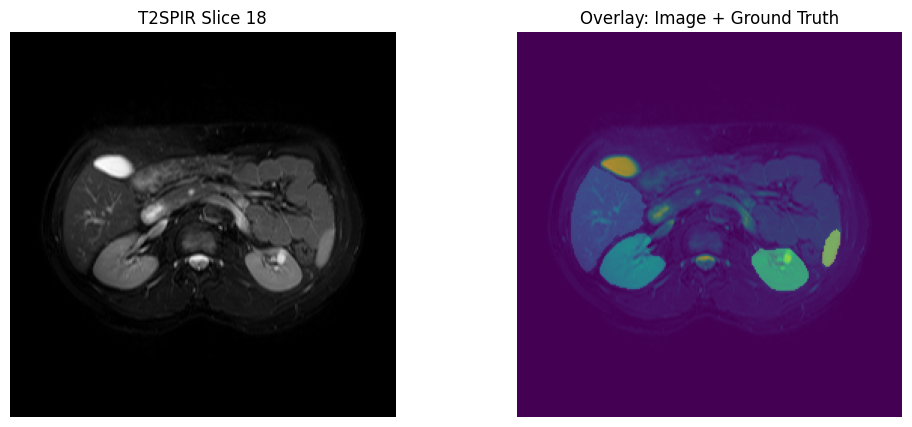

In [18]:
# Visualize an example of a T2SPIR image with its corresponding mask for patient 1
slice_idx = len(volume) // 2  # middle slice

image = volume[slice_idx]
mask = masks[slice_idx % len(masks)]  # handle mismatch in slice count if any

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title(f"T2SPIR Slice {slice_idx}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(mask, alpha=0.4)
plt.title("Overlay: Image + Ground Truth")
plt.axis('off')
plt.show()


Volume shape: (35, 256, 256)
Number of masks: 35


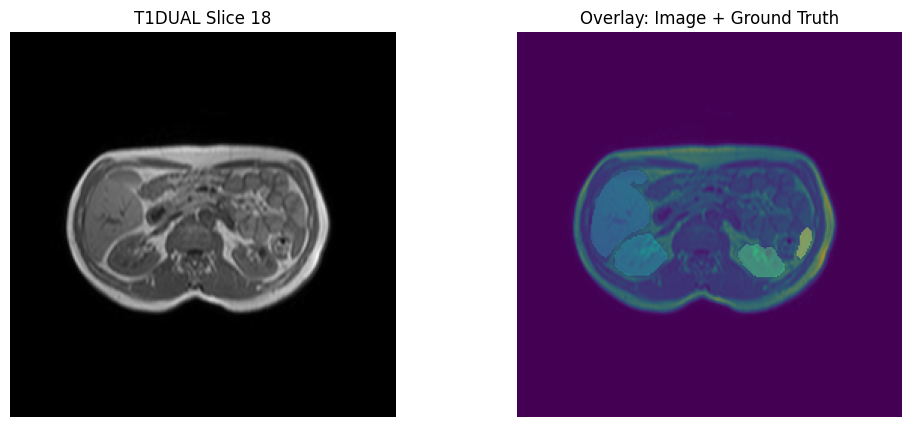

In [19]:
# Repeat the same procedure for the T1DUAL InPhase modality of patient 1
# List DICOM files
dcm_files = [os.path.join(t1_dual_in_images_path, f) for f in os.listdir(t1_dual_in_images_path) if f.endswith(".dcm")]

# Read and sort by instance number
slices = [pydicom.dcmread(f) for f in dcm_files]
slices.sort(key=lambda x: int(x.InstanceNumber))

# Convert to numpy volume
volume = np.stack([s.pixel_array for s in slices], axis=0)

print("Volume shape:", volume.shape)

# Verify Masks
mask_files = sorted([os.path.join(t1_dual_masks_path, f) for f in os.listdir(t1_dual_masks_path) if f.endswith(".png")])

# Read as numpy arrays
masks = [np.array(Image.open(f)) for f in mask_files]
print("Number of masks:", len(masks))

# Visualize an example of a T1DUAL InPhase image with its corresponding mask for patient

image = volume[slice_idx]
mask = masks[slice_idx % len(masks)]  # handle mismatch in slice count if any

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title(f"T1DUAL Slice {slice_idx}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(mask, alpha=0.4)
plt.title("Overlay: Image + Ground Truth")
plt.axis('off')
plt.show()


Volume shape: (35, 256, 256)
Number of masks: 35


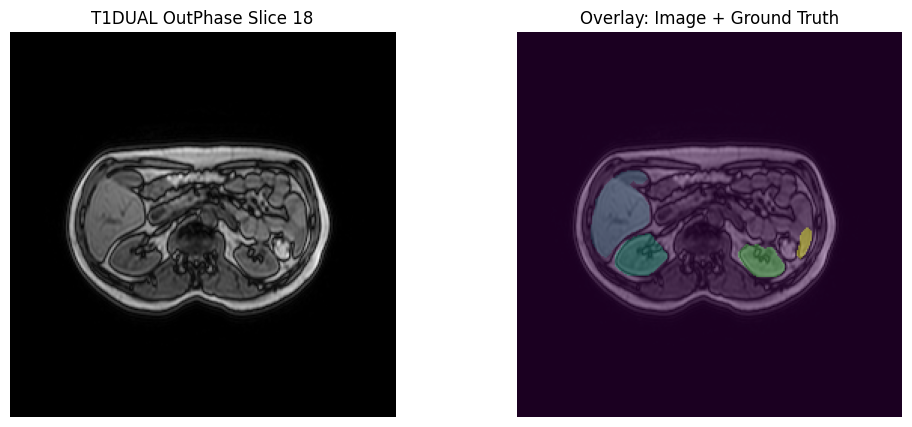

In [20]:
#Repeat the same procedure for the T1DUAL OutPhase modality of patient 1.
# List DICOM files
dcm_files = [os.path.join(t1_dual_out_images_path, f) for f in os.listdir(t1_dual_out_images_path) if f.endswith(".dcm")]

# Read and sort by instance number
slices = [pydicom.dcmread(f) for f in dcm_files]
slices.sort(key=lambda x: int(x.InstanceNumber))

# Convert to numpy volume
volume = np.stack([s.pixel_array for s in slices], axis=0)

print("Volume shape:", volume.shape)

# Verify Masks
mask_files = sorted([os.path.join(t1_dual_masks_path, f) for f in os.listdir(t1_dual_masks_path) if f.endswith(".png")])

# Read as numpy arrays
masks = [np.array(Image.open(f)) for f in mask_files]
print("Number of masks:", len(masks))

# Visualize an example of a T1DUAL OutPhase image with its corresponding mask for patient

image = volume[slice_idx]
mask = masks[slice_idx % len(masks)]  # handle mismatch in slice count if any

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title(f"T1DUAL OutPhase Slice {slice_idx}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image, cmap='gray')
plt.imshow(mask, alpha=0.4)
plt.title("Overlay: Image + Ground Truth")
plt.axis('off')
plt.show()


### Exploratory Data Analysis (EDA)

In [21]:
# Slice Verification and Patient Overview
data_summary = []

modalities = {
    "T2SPIR": ["DICOM_anon"],
    "T1DUAL InPhase": ["DICOM_anon", "InPhase"],
    "T1DUAL OutPhase": ["DICOM_anon", "OutPhase"]
}

for patient in patients:
    row = {"Patient": patient}
    for mod_name, subfolders in modalities.items():
        img_folder = os.path.join(base_dir, patient, mod_name.split()[0], *subfolders)
        mask_folder = os.path.join(base_dir, patient, mod_name.split()[0], "Ground")

        if os.path.exists(img_folder) and os.path.exists(mask_folder):
            n_imgs = len([f for f in os.listdir(img_folder) if f.endswith(".dcm")])
            n_masks = len([f for f in os.listdir(mask_folder) if f.endswith(".png")])
            status = "✅" if n_imgs == n_masks else "⚠️"
        else:
            n_imgs, n_masks, status = 0, 0, "❌"
        row[f"{mod_name}"] = f"{n_imgs}/{n_masks} {status}"
    data_summary.append(row)

df_summary = pd.DataFrame(data_summary)
df_summary


,Patient,T2SPIR,T1DUAL InPhase,T1DUAL OutPhase
0,1,36/36 ✅,35/35 ✅,35/35 ✅
1,10,36/36 ✅,50/50 ✅,50/50 ✅
2,13,30/30 ✅,30/30 ✅,30/30 ✅
3,15,26/26 ✅,26/26 ✅,26/26 ✅
4,19,30/30 ✅,30/30 ✅,30/30 ✅
5,2,26/26 ✅,26/26 ✅,26/26 ✅
6,20,26/26 ✅,26/26 ✅,26/26 ✅
7,21,31/31 ✅,34/34 ✅,34/34 ✅
8,22,33/33 ✅,35/35 ✅,35/35 ✅
9,3,30/30 ✅,30/30 ✅,30/30 ✅


The number of slices varies between patients and can also differ between modalities (T1-DUAL or T2-SPIR) for the same patient. Importantly, every image has a corresponding ground truth mask, so there are no missing annotations.


Patient: 34


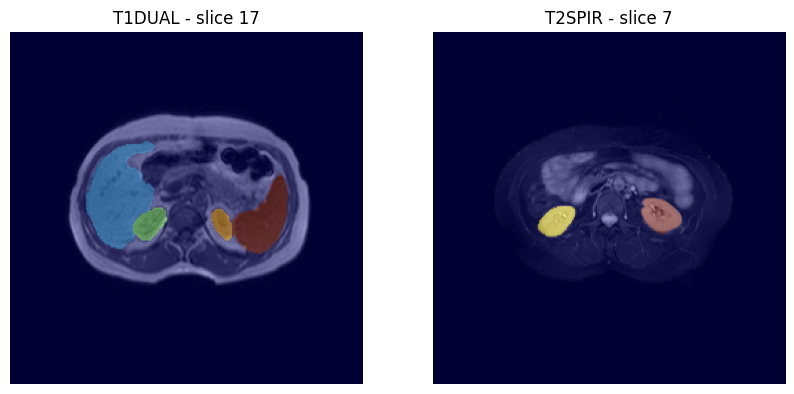


Patient: 21


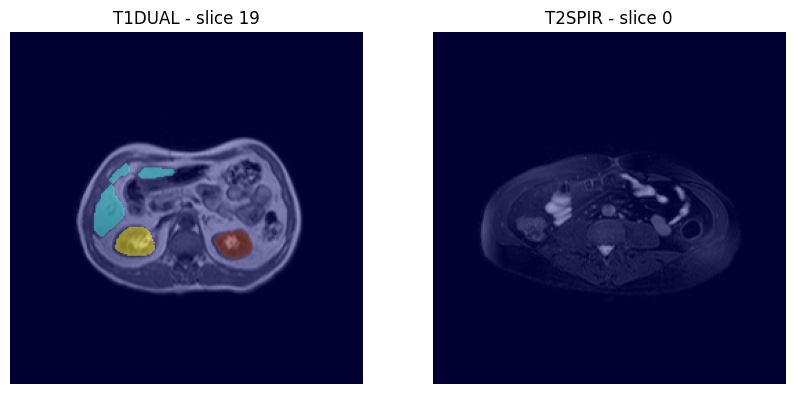


Patient: 8


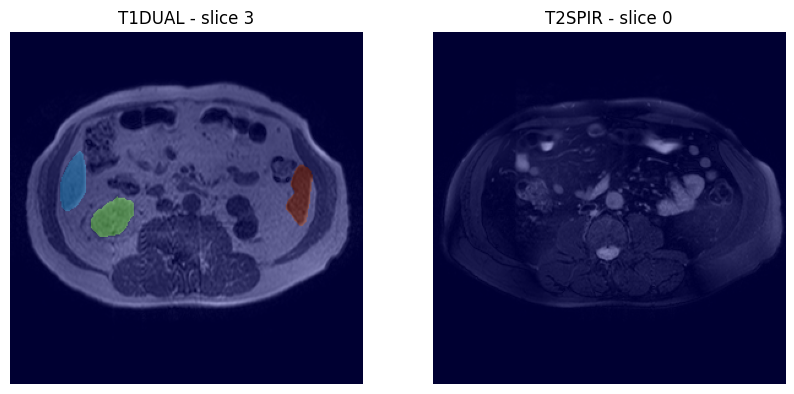

In [22]:
# Example Visualizations
# 2D Visualizations
# Choose random patients and modalities
sample_patients = random.sample(patients, 3)  # show 3 different patients
modalities = ["T1DUAL", "T2SPIR"]

for patient in sample_patients:
    print(f"\nPatient: {patient}")
    fig, axs = plt.subplots(1, len(modalities), figsize=(10, 5))

    for i, modality in enumerate(modalities):
        if modality == "T1DUAL":
            img_folder = os.path.join(base_dir, patient, modality, "DICOM_anon", "InPhase")  # or "outphase"
        else:
            img_folder = os.path.join(base_dir, patient, modality, "DICOM_anon")

        mask_folder = os.path.join(base_dir, patient, modality, "Ground")

        # Get one random slice from this modality
        img_files = sorted([os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith(".dcm")])
        mask_files = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith(".png")])

        if len(img_files) == 0 or len(mask_files) == 0:
            axs[i].axis("off")
            axs[i].set_title(f"{modality}: no data")
            continue

        idx = random.randint(0, min(len(img_files), len(mask_files)) - 1)
        img_path = img_files[idx]
        mask_path = mask_files[idx]

        # Read image and mask
        img = pydicom.dcmread(img_path).pixel_array.astype(np.float32)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Simple scaling just for visualization
        img = img / np.max(img)

        axs[i].imshow(img, cmap="gray")
        axs[i].imshow(mask, cmap="jet", alpha=0.4)  # overlay mask
        axs[i].set_title(f"{modality} - slice {idx}")
        axs[i].axis("off")

    plt.show()


In [23]:
# 3D Visualizations
from ipywidgets import interact

# Choose a sample patient and modality
patient = random.choice(patients)
modalities = ["T1DUAL", "T2SPIR"]

for modality in modalities:
    print(f"\nPatient: {patient}, Modality: {modality}")

    if modality == "T1DUAL":
        img_folder = os.path.join(base_dir, patient, modality, "DICOM_anon", "InPhase")  # or "OutPhase"
    else:
        img_folder = os.path.join(base_dir, patient, modality, "DICOM_anon")

    mask_folder = os.path.join(base_dir, patient, modality, "Ground")

    # Load all slices
    img_files = sorted([f for f in os.listdir(img_folder) if f.endswith(".dcm")])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])

    # Stack volumes
    img_volume = np.stack([pydicom.dcmread(os.path.join(img_folder, f)).pixel_array.astype(np.float32) for f in img_files])
    mask_volume = np.stack([cv2.imread(os.path.join(mask_folder, f), cv2.IMREAD_GRAYSCALE) for f in mask_files])

    # Check
    print(f"Loaded {img_volume.shape[0]} image slices and {mask_volume.shape[0]} mask slices")

    # Simple scaling just for visualization
    img_volume /= np.max(img_volume)

    # Interactive viewer
    def view_slice(slice_idx=0):
        plt.figure(figsize=(5,5))
        plt.imshow(img_volume[slice_idx], cmap="gray")
        plt.imshow(mask_volume[slice_idx], cmap="jet", alpha=0.4)
        plt.title(f"{modality} - Slice {slice_idx}")
        plt.axis("off")
        plt.show()

    # Use the actual number of slices
    interact(view_slice, slice_idx=(0, img_volume.shape[0]-1))




Patient: 8, Modality: T1DUAL
Loaded 36 image slices and 36 mask slices


interactive(children=(IntSlider(value=0, description='slice_idx', max=35), Output()), _dom_classes=('widget-in…


Patient: 8, Modality: T2SPIR
Loaded 32 image slices and 32 mask slices


interactive(children=(IntSlider(value=0, description='slice_idx', max=31), Output()), _dom_classes=('widget-in…

In [24]:
# Explore Slice Properties
# One slice Properties for a patient patient for example
patient=patients[8]
modality = "T1DUAL"
img_folder = os.path.join(base_dir, patient, modality, "DICOM_anon","InPhase")
mask_folder = os.path.join(base_dir, patient, modality, "Ground")

if not os.path.exists(img_folder) or not os.path.exists(mask_folder):
    print(f"Skipping {patient} ({modality}) - folder missing")

img_files = sorted([os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith(".dcm")])
mask_files = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith(".png")])
slice_idx=20
img_path = os.path.join(base_dir, patient, modality, "DICOM_anon","InPhase",img_files[slice_idx])
mask_path = os.path.join(base_dir, patient, modality, "Ground",mask_files[slice_idx])
# Read DICOM image
img = pydicom.dcmread(img_path).pixel_array.astype(np.float32)
print("Image shape:", img.shape)
print("Intensity range:", np.min(img), "to", np.max(img))
# Read paletted mask using Pillow
mask = np.array(Image.open(mask_path))
print("Mask shape:", mask.shape)
print("Unique labels in mask:", np.unique(mask))

Image shape: (256, 256)
Intensity range: 0.0 to 1708.0
Mask shape: (256, 256)
Unique labels in mask: [  0  63 252]


The selected slice has a standard image and mask size of 256×256 pixels. The voxel intensity values range from 0 to 1708, which is typical for MRI data depending on the modality. The corresponding mask has the same spatial dimensions and includes three distinct label values (0, 63, 252), representing different anatomical regions or organs.

In [25]:
# Check compatibility of images size for each patient within same modality
n=0
for patient in patients:  # loop over all patients
    for modality in modalities:
        mask_folder = os.path.join(base_dir, patient, modality, "Ground")
        mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])
        if not mask_files:
            continue

        # Get all slice shapes
        slice_sizes = [np.array(Image.open(os.path.join(mask_folder, f))).shape for f in mask_files]
        size_counts = Counter(slice_sizes)

        if len(size_counts) == 1:
           n+=1
        else:
            print("  ⚠️  Slices with different sizes found:")
            for size, count in size_counts.items():
                print(f"    {size}: {count} slices")
        if n==40:
          print("All slices for every patient within same modality have the same size")


All slices for every patient within same modality have the same size



Patients where T1 and T2 mask sizes are different: ['13', '19', '2', '20', '3', '38']
Total: 6/20


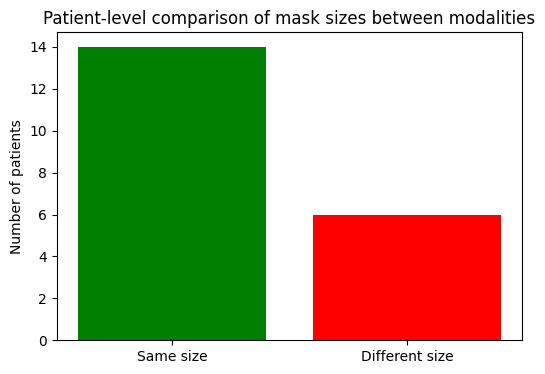

In [26]:
# Check that for the same patient, both modalities have the same image size
size_match = []

for patient in patients:
    mask_sizes = []
    for modality in modalities:
        mask_folder = os.path.join(base_dir, patient, modality, "Ground")
        mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])
        if not mask_files:
            continue
        mask = np.array(Image.open(os.path.join(mask_folder, mask_files[0])))
        mask_sizes.append(mask.shape)

    # True if same, False if different
    size_match.append((patient, mask_sizes[0] == mask_sizes[1]))

# List of patients where mask sizes differ
patients_diff_size = [patient for patient, match in size_match if not match]

print(f"\nPatients where T1 and T2 mask sizes are different: {patients_diff_size}")
print(f"Total: {len(patients_diff_size)}/{len(patients)}")

# Bar plot
match_count = sum([1 for _, m in size_match if m])
plt.figure(figsize=(6,4))
plt.bar(["Same size", "Different size"], [match_count, len(patients)-match_count], color=['green','red'])
plt.title("Patient-level comparison of mask sizes between modalities")
plt.ylabel("Number of patients")
plt.show()



Modality T1-DUAL - Sizes across patients:
  Size (256, 256): 13 patients
  Size (288, 288): 7 patients
  ⚠️ Patients with uncommon sizes: ['13', '19', '2', '20', '3', '38', '8']


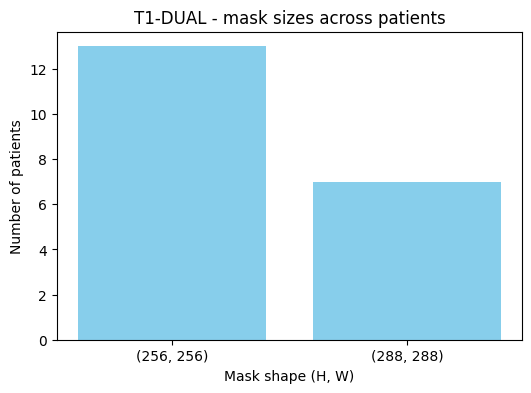


Modality T2-SPIR - Sizes across patients:
  Size (256, 256): 13 patients
  Size (320, 320): 6 patients
  Size (288, 288): 1 patients
  ⚠️ Patients with uncommon sizes: ['13', '19', '2', '20', '3', '38', '8']


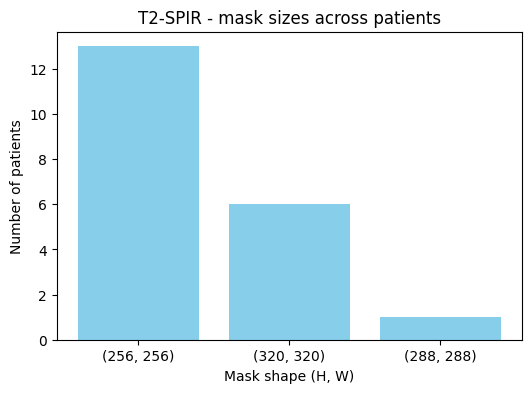

In [27]:
# Check that all images for a single modality have the same size across all patients
modalities = ["T1DUAL", "T2SPIR"]
modality_names = {"T1DUAL": "T1-DUAL", "T2SPIR": "T2-SPIR"}

for modality in modalities:
    sizes = []
    patient_sizes = {}  # store each patient's size
    for patient in patients:
        mask_folder = os.path.join(base_dir, patient, modality, "Ground")
        mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])
        if not mask_files:
            continue

        # Take first mask of the patient for this modality
        mask = np.array(Image.open(os.path.join(mask_folder, mask_files[0])))
        sizes.append(mask.shape)
        patient_sizes[patient] = mask.shape

    # Count occurrences of each size
    size_counts = Counter(sizes)
    print(f"\nModality {modality_names[modality]} - Sizes across patients:")
    for size, count in size_counts.items():
        print(f"  Size {size}: {count} patients")

    # Identify patients with uncommon sizes
    most_common_size = size_counts.most_common(1)[0][0]
    uncommon_patients = [p for p, s in patient_sizes.items() if s != most_common_size]

    if uncommon_patients:
        print("  ⚠️ Patients with uncommon sizes:", uncommon_patients)
    else:
        print("  ✅ All patients have the same mask size")

    # Bar plot
    plt.figure(figsize=(6,4))
    plt.bar([str(s) for s in size_counts.keys()], size_counts.values(), color='skyblue')
    plt.title(f"{modality_names[modality]} - mask sizes across patients")
    plt.ylabel("Number of patients")
    plt.xlabel("Mask shape (H, W)")
    plt.show()

All slices for each patient within the same modality have consistent sizes, which ensures intra-patient consistency. However, a few patients show differences between T1-DUAL and T2-SPIR mask sizes, and some T1-DUAL images have a larger size (288×288) compared to the standard (256×256).

These differences could affect model training since deep learning networks require fixed input sizes. They can be addressed during preprocessing by resizing or resampling images and masks to a common shape. Given that most images already have the standard size, this step is manageable, though care should be taken to preserve anatomical accuracy when resizing masks.

In [28]:
# Verify the number of classes in images

mask_folder_paths = []  # store all mask paths
for patient in patients:
    mask_folder = os.path.join(base_dir, patient, "T2SPIR", "Ground")
    if os.path.exists(mask_folder):
        mask_folder_paths.extend([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith(".png")])

# Collect unique labels for all masks
all_labels = set()
for mask_path in mask_folder_paths:
    mask = np.array(Image.open(mask_path))
    unique_labels = np.unique(mask)
    all_labels.update(unique_labels)

print("All unique mask labels in the dataset:", sorted(all_labels))
print("Number of classes (including background):", len(all_labels))


All unique mask labels in the dataset: [np.uint8(0), np.uint8(63), np.uint8(126), np.uint8(189), np.uint8(252)]
Number of classes (including background): 5


In [29]:
# Verify the number of classes in images

mask_folder_paths = []  # store all mask paths
for patient in patients:
    mask_folder = os.path.join(base_dir, patient, "T1DUAL","Ground")
    if os.path.exists(mask_folder):
        mask_folder_paths.extend([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.endswith(".png")])

# Collect unique labels for all masks
all_labels = set()
for mask_path in mask_folder_paths:
    mask = np.array(Image.open(mask_path))
    unique_labels = np.unique(mask)
    all_labels.update(unique_labels)

print("All unique mask labels in the dataset:", sorted(all_labels))
print("Number of classes (including background):", len(all_labels))

All unique mask labels in the dataset: [np.uint8(0), np.uint8(63), np.uint8(126), np.uint8(189), np.uint8(252)]
Number of classes (including background): 5


The dataset contains 5 unique mask labels, corresponding to the background and the four abdominal organs of interest. Specifically, the labels are 0 for background, 63 for liver, 126 for the right kidney, 189 for the left kidney, and 252 for the spleen. This confirms that each mask encodes all target structures consistently, and the number of classes matches the expected segmentation task.


In [30]:
#CLASS DISTRIBUTION ACROSS DATA SET
class_counter = Counter()
for mask_path in mask_folder_paths:
    mask = np.array(Image.open(mask_path))
    for label in np.unique(mask):
        class_counter[label] += 1

print("Slices per class:", class_counter)


Slices per class: Counter({np.uint8(0): 647, np.uint8(63): 431, np.uint8(189): 272, np.uint8(126): 264, np.uint8(252): 242})


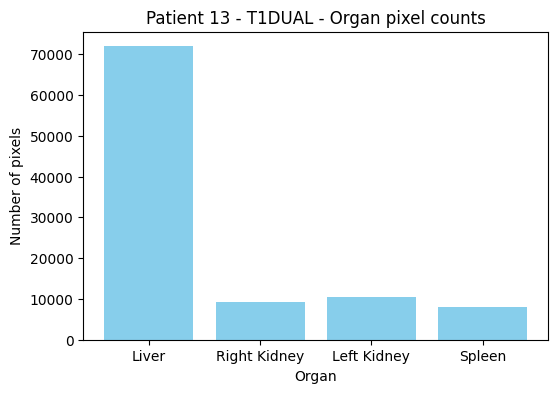

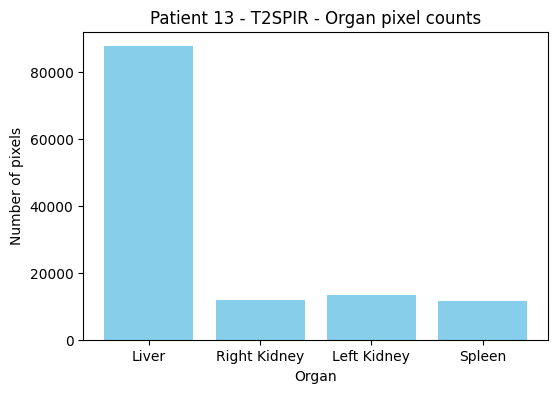

In [31]:
# Choose a few random patients
sample_patients = random.sample(patients,1)  # random patient
modalities = ["T1DUAL", "T2SPIR"]

# Mapping of intensity values to organ names
class_mapping = {
    63: "Liver",
    126: "Right Kidney",
    189: "Left Kidney",
    252: "Spleen"
}

for patient in sample_patients:
    for modality in modalities:
        mask_folder = os.path.join(base_dir, patient, modality, "Ground")
        mask_files = [f for f in os.listdir(mask_folder) if f.lower().endswith(".png")]

        # Initialize dictionary to count pixels per organ
        class_sizes = {name: 0 for name in class_mapping.values()}

        # Count pixels for each organ across all slices
        for mask_file in mask_files:
            mask = np.array(Image.open(os.path.join(mask_folder, mask_file)))
            for intensity, organ_name in class_mapping.items():
                class_sizes[organ_name] += np.sum(mask == intensity)

        # Convert to percentage (excluding background)
        total_pixels = sum(class_sizes.values())
        class_percent = {k: v/total_pixels*100 for k, v in class_sizes.items()}

        # Bar chart
        plt.figure(figsize=(6,4))
        plt.bar(class_sizes.keys(), class_sizes.values(), color="skyblue")
        plt.title(f"Patient {patient} - {modality} - Organ pixel counts")
        plt.xlabel("Organ")
        plt.ylabel("Number of pixels")
        plt.show()